In [20]:
from abc import ABC, abstractmethod
import glob
import json
import os
import sys
from time import time, gmtime, strftime
from typing import Tuple, Dict, List

import cv2
import matplotlib.pyplot as plt
import numpy as np
import spectral as sp
from scipy.stats import chi2

import utils as ut

## Loading Data

In [21]:
def read_images(
        input_dir: str,
        mask: np.ndarray,
        homographies: Dict[str, List[List[float]]]
) -> Tuple[Dict[str, Dict[str, Dict[str, np.ndarray]]], Dict[str, Dict[str, Dict[str, np.ndarray]]]]:
    """
    Finds all .png files recursively in a given input directory. The images are loaded,
    a mask is applied to filter unwanted regions of the images and the images get
    warped based on the provided homographies.
    With this dictionary structure it can be assured that the images of one
    image set always go together.

    Args:
        input_dir: Input directory which contains .png images
        mask: Filter to mask out unwanted regions of all images at the same position
        homographies: Dictionary mapping the file name to the associated homography

    Returns:
        A tuple containing 2 dictionaries for the original and warped images.
        Each dictionary is structured as follows:
            {Folder Name (e.g. "valid-1-0"): {File Set Number (e.g. 0): {File Name (e.g. 0-B01): Image as array}}}
    """
    input_dir = os.path.abspath(input_dir)

    sorted_files = sorted(glob.glob(
        os.path.join(input_dir, '**', '*.png'),
        recursive=True
    ))

    original_images = {}
    warped_images = {}

    for file in sorted_files:
        folders, file_name = os.path.split(file)
        file_name = file_name.split('.')[0]
        folder_name = os.path.basename(folders)
        file_set = file_name.split('-')[0]

        if folder_name not in original_images and folder_name not in warped_images:
            original_images[folder_name] = {}
            warped_images[folder_name] = {}

        if file_set not in original_images[folder_name] and file_set not in warped_images[folder_name]:
            original_images[folder_name].update({file_set: {}})
            warped_images[folder_name].update({file_set: {}})

        img = cv2.imread(file)
        w, h, _ = img.shape
        img = cv2.bitwise_and(img,img,mask=mask) #apply the mask to remove the timestamp
        original_images[folder_name][file_set].update({file_name: img}) #save the original

        homography = np.array(homographies[file_name]) #get homography

        warped_img = cv2.warpPerspective(img, homography, (w,h)) #warp the image using the given homography
        warped_images[folder_name][file_set].update({file_name: warped_img})

    return original_images, warped_images



In [22]:
MASK = 'data/mask.png'
IMAGE_FOLDER = 'data/validation/valid-1-0/'

mask = cv2.imread(MASK,0)
homographies = json.loads(open(IMAGE_FOLDER+'homographies.json','r').read())

#images = []

orig_images, warped_images = read_images(IMAGE_FOLDER, mask, homographies)

In [23]:
MASK = 'data/mask.png'
IMAGE_FOLDER = 'data/validation/valid-1-0/'

mask = cv2.imread(MASK,0)
homographies = json.loads(open(IMAGE_FOLDER+'homographies.json','r').read())

#images = []

orig_images = []
warped_images = []

for root, dirs, files in os.walk(IMAGE_FOLDER):
    for file in files:
        if file.endswith('.png'):
            img = cv2.imread(os.path.join(root,file))
            w,h,_ = img.shape
            res = cv2.bitwise_and(img,img,mask=mask) #apply the mask to remove the timestamp
            orig_images.append(res) #save the original

            w,h,_ = img.shape
            name = file.replace('.png','')
            M = np.array(homographies[name]) #get homography

            res = cv2.warpPerspective(res, M, (w,h)) #warp the image using the given homography
            warped_images.append(res)

## Utils & Integration

In [24]:
def display_images(images, figsize=None, resize_dim=(200, 200)):
    if figsize: row, col = figsize
    else: row, col = 1,1
        
    fig, axs = plt.subplots(row, col, figsize=figsize)
    if row>1 or col>1: axs = axs.flatten()
    else: axs = [axs]
    fig.set_figwidth(20)
    fig.set_figheight(15)
    
    for img, ax in zip(images, axs):
        ax.imshow(cv2.resize(img, resize_dim), interpolation='nearest')
        
    plt.show()

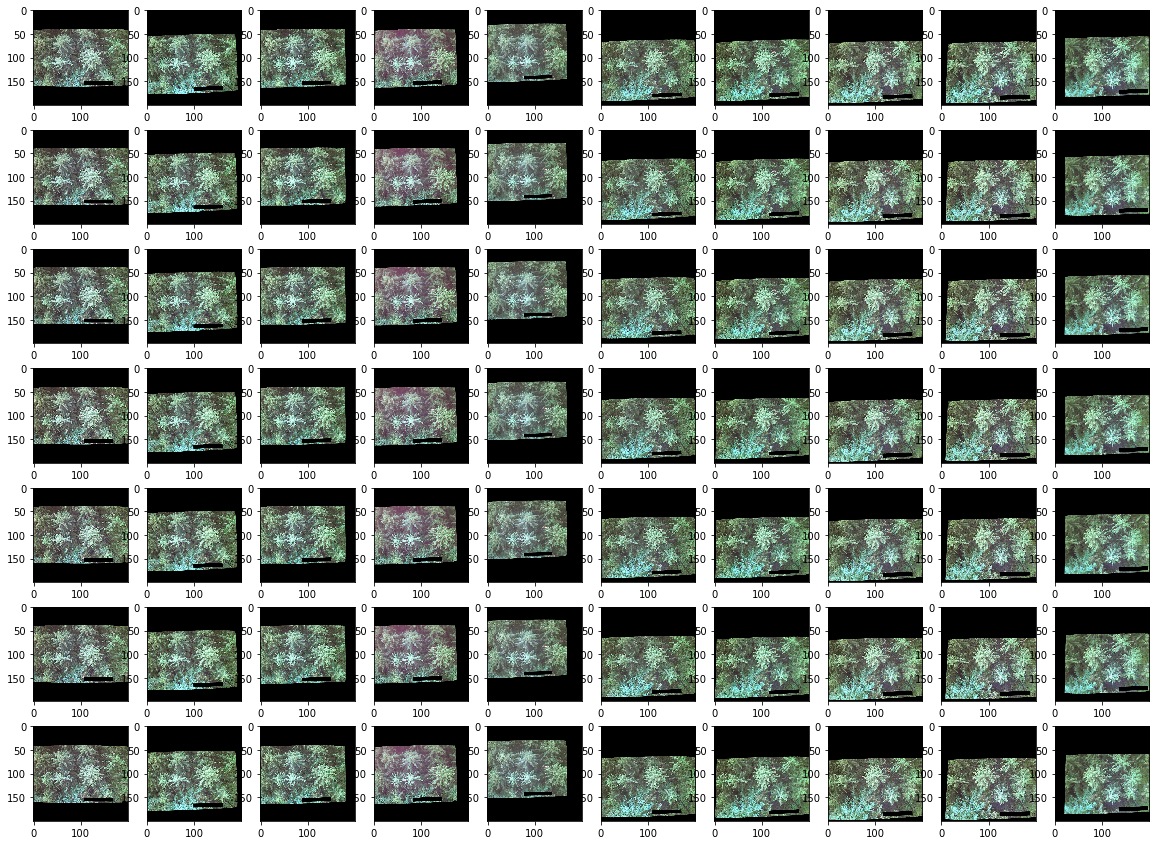

In [25]:
display_images(np.array(warped_images), figsize=(7,10), resize_dim=(200,200))
#display_images(np.array(orig_images), figsize=(7,10), resize_dim=(200,200))

In [50]:
def integrate(images: np.ndarray):

    integrated_images = []
    mask_images = []
    """
    This is going through all the sets of images,True
    where images[0] represents 10 images in a numpy array
    """
    for i in range(len(images)): 
        integral = np.zeros((images[0].shape[1:]), np.float64)
        mask = np.zeros((images[0].shape[1:]), np.float64)
        mask = mask[:,:,0]
        mask_ = np.copy(mask)

        for j in range(len(images[i])):
            integral += images[i][j]
            
            height, width, _ = images[i][j].shape
            for x in range(height):
                for y in range(width):
                    if all(images[i][j][x,y] == [0,0,0]):
                        mask[x,y] += 1
        
        x,y = mask.shape
        for n in range(x):
            for m in range(y):
                if mask[n,m] == 0:
                    mask_[n,m] = 1
                else:
                    mask_[n,m] = 0
        
        #cv2.cvtColor(np.float32(mask_),cv2.COLOR_GRAY2BGR)

        mask_images.append(mask_)
        integral /= len(images[i]) 
        integral=cv2.normalize(integral, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        integrated_images.append(integral)

    return integrated_images , mask_images

In [27]:
def color_check(image: np.ndarray):
    height, width = image.shape[:2]
    cc = np.zeros(image.shape, np.float64)
    for y,x in zip(range(height),range(width)):
        if all(image[x,y] != [0,0,0]):
            cc[x,y]=[0,0,0]
    return np.array(cc)


In [28]:
def crop_image(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _,thresh = cv2.threshold(grayscale,0,255,cv2.THRESH_OTSU)

    bbox = cv2.boundingRect(thresh)
    x,y,w,h = bbox
    
    return x,y,w,h


# Integrating Images and Computing Image Masks
Image mask are a mask created using the area of the integrated images where all 10 of the input frames are a part of the integrated image. This ensures that we only look at image data where all 10 images are being used.

In [126]:
integrated_images, mask_images = integrate(np.array_split(warped_images,7))

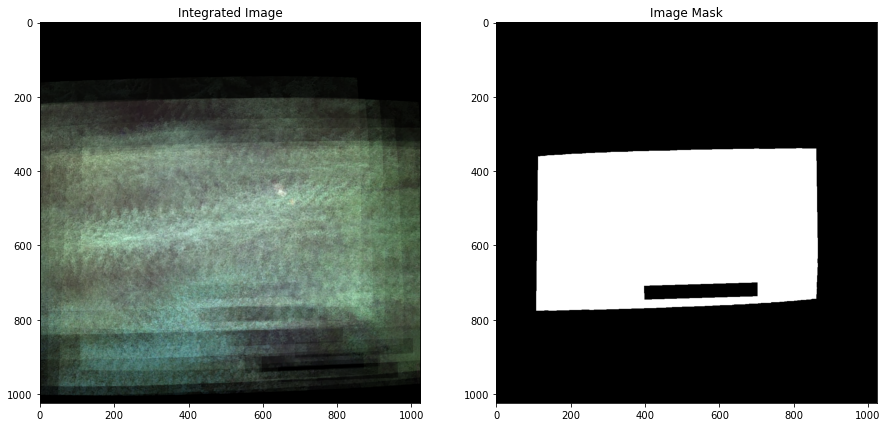

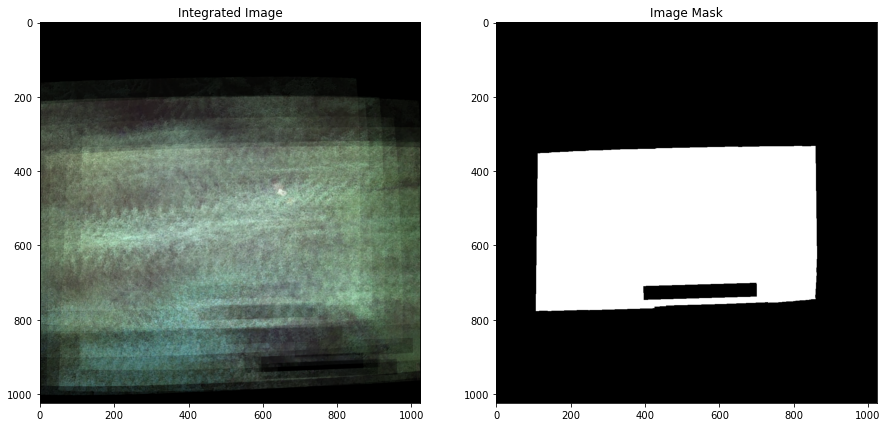

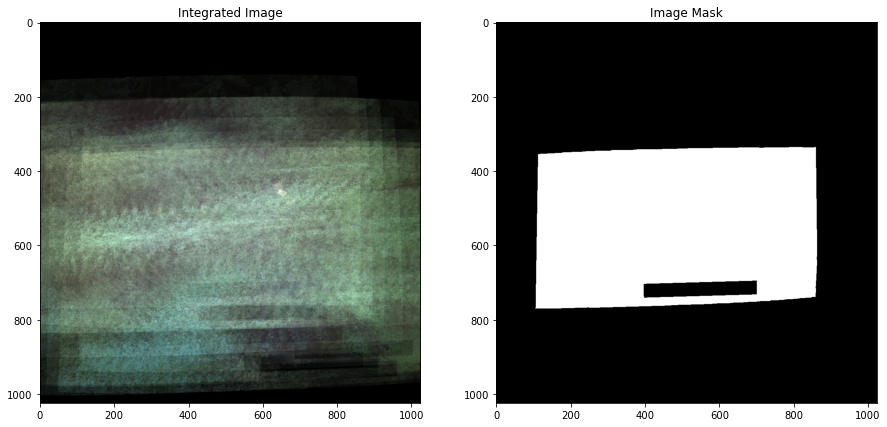

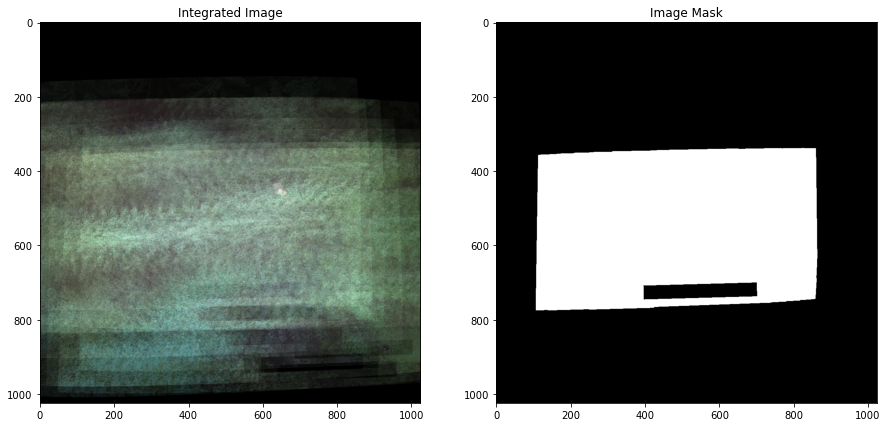

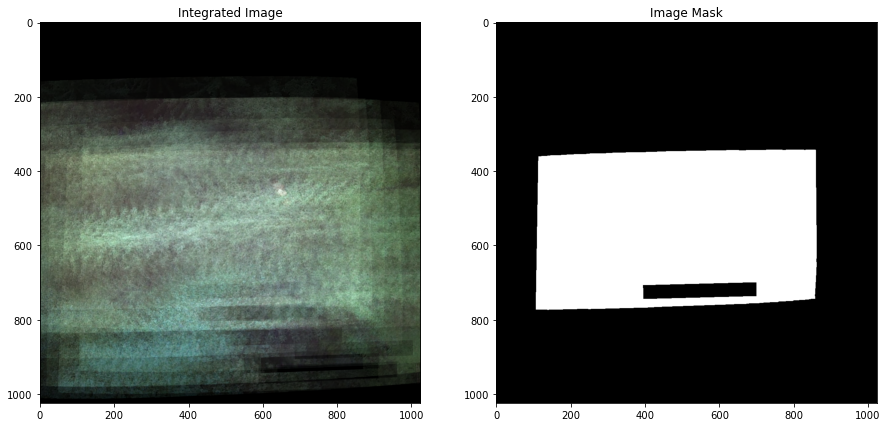

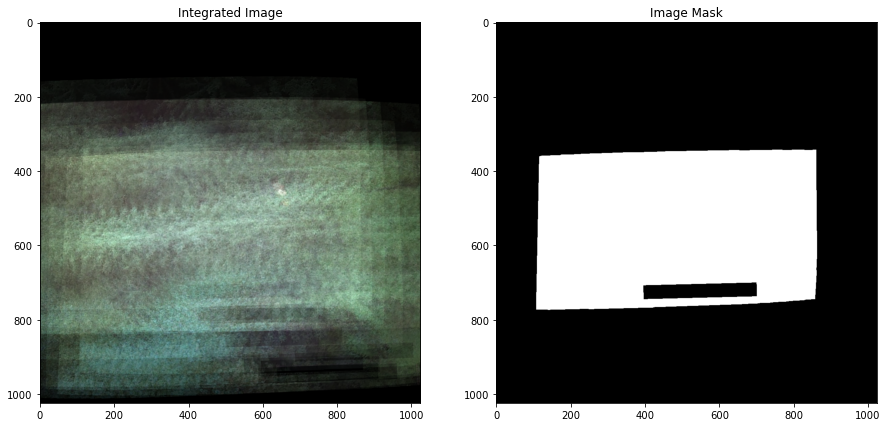

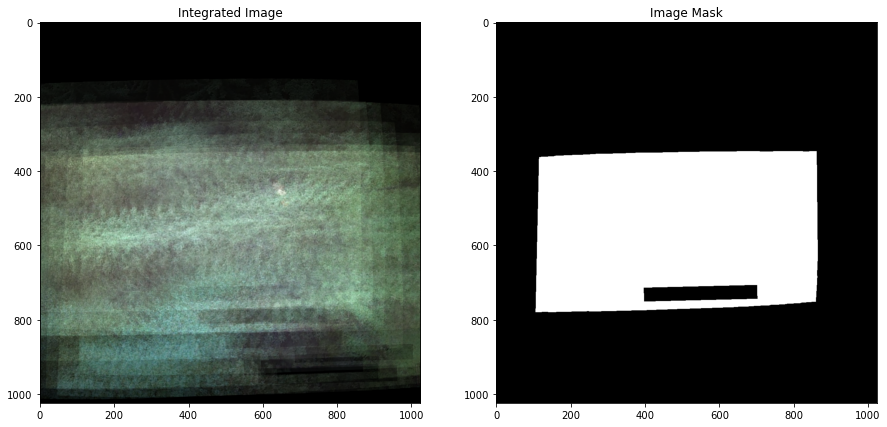

In [128]:
"""
Just displaying the output from the previous step to confirm results
"""

m_img=[]
for i in range(len(mask_images)):
    m_img.append(cv2.cvtColor(mask_images[i].astype('uint8')*255, cv2.COLOR_GRAY2BGR))

a=np.array(integrated_images)
b=np.array(m_img)
c=np.concatenate((a,b),axis=0)

for i in range(len(a)):
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    ax1.imshow(a[i])
    ax1.title.set_text("Integrated Image")

    ax2 = fig.add_subplot(122)
    ax2.imshow(b[i])
    ax2.title.set_text("Image Mask")

#display_images(a, figsize=(1,7), resize_dim=(400,400))
#display_images(b, figsize=(1,7), resize_dim=(400,400))
#display_images(c, figsize=(2,7), resize_dim=(400,400))

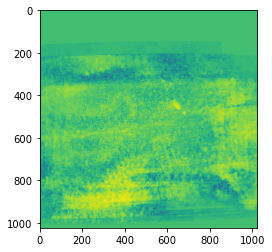

In [129]:
rxvals = []

for img in integrated_images:
    rxvals.append(sp.rx(img))

nbands = integrated_images[0].shape[-1]
P=chi2.ppf(0.99999, nbands)

#v=plt.imshow(1*(rxvals[0]>P))
v = plt.imshow(np.log(rxvals[0]))
#print(rxvals[0])

## Anomaly Detection

I think it is good if we use a proper base class for the anomaly detection, this should ensure a unified interface which can be used at any point in our pipeline. Basically any algorithm implementation / class should have the method `anomaly_mask` which should return a mask where outliers are marked with 1 and other pixels remain 0.

In [130]:
class AnomalyDetection(ABC):
    def __init__(self, img: np.ndarray):
        self.img = img

    @abstractmethod
    def anomaly_mask(self) -> np.ndarray:
        """
        Takes whatever is necessary from the current object to generate an anomaly
        mask. The mask has the same height and width as the input image, anomalies are
        marked as 1, everything als with 0.
        """
        pass

### Reed-Xiaoli Detector
This anomaly detection algorithm is the baseline, which should not be used. Nevertheless it is good to have it implemented for comparisons.

In [131]:
class ReedXiaoliAnomaly(AnomalyDetection):
    def __init__(
            self,
            img: np.ndarray,
            conf_coef: float = 0.999,
            verbose: bool = False
    ):
        super().__init__(img)
        self.conf_coef = conf_coef
        self.verbose = verbose
        self.D_rx = None
        self.mask = None

    def _rxd(self):
        """
        Implementation of the Reed-Xiaoli detector. Calculates a score for each pixel as the
        Mahalanobis distance between the pixel and the background.

        Args:
            img: Image in the shape Height x Width x 3

        Returns:
            Numpy array with the Mahalanobis distance of each pixel with shape Height x Width of the input image
        """
        h, w, c = self.img.shape

        # Calculate Mean Vector
        mean_vec = np.mean(img, axis=(0, 1))

        # Calculate Covariance Matrix
        img_tmp = img.copy()
        img_tmp = img_tmp.astype('float32') - mean_vec
        img_tmp = img_tmp.reshape(-1, 3)
        cov_mat = (img_tmp.T @ img_tmp) / (img_tmp.shape[0] - 1)

        # Initialize Result Matrix
        D_rx = np.zeros((h,w))

        # Calculate Mahalanobis distance
        for i in range(h):
            for j in range(w):
                r = img[i,j]
                r_normal = r - mean_vec
                D_rx[i,j] = r_normal.T @ np.linalg.inv(cov_mat) @ r_normal

        return D_rx

    def anomaly_mask(self) -> np.ndarray:
        """
        Calculates a threshold for the values of the RX-detector in order to find
        only the most extreme anomalies which have a higher RX-score than conf_coef %
        of the values in the array. All values below this threshold are set to 0.
        If verbose is True, then the cumulative probability density of the rxd_array is
        printed alongside the returned mask.

        Returns:
            Anomaly mask where anomalies are 0, everything else is 0
        """
        self.D_rx = self._rxd()
        rxd_arr = self.D_rx.copy()
        rxd_sorted = np.sort(rxd_arr.flatten())
        prob = 1. * np.arange(len(rxd_sorted)) / (len(rxd_sorted) - 1)

        threshold_idx = np.argwhere(prob > self.conf_coef)[0][0]
        threshold = rxd_sorted[threshold_idx]

        mask = np.where(rxd_arr > threshold, 1, 0)
        # mask = rxd_arr > threshold
        # rxd_arr[mask] = 1
        # rxd_arr[~mask] = 0

        self.mask = mask

        if self.verbose:
            fig = plt.figure(figsize=(15,7))
            ax1 = fig.add_subplot(121)
            ax1.plot(rxd_sorted, prob)
            ax1.title.set_text("CDF of RX-Values")
            ax1.set_xlabel("RX Value")
            ax1.set_ylabel("Cumulative Probability")

            ax2 = fig.add_subplot(122)
            ax2.imshow(rxd_arr)
            ax2.title.set_text("Anomaly Mask")

        return self.mask

### Residual Approach

Originally this should be an implementation from `Reducing Anomaly Detection in Images to Detection in Noise` by Davy et al. The implementation is heavily influenced from this [GitHub Repository](https://github.com/whynotw/reducing_anomaly_detection), however by pure chance I stumbled across the fact that a burred version of the residual image is already looking promising for detection outliers. <br>
A disadvantage is that this algorithm takes ~1 min. per image to create the anomaly mask!

In [132]:
class ResidualAnomaly(AnomalyDetection):
    def __init__(
            self,
            img: np.ndarray,
            filter_size: int = 7,
            stride: int = 3,
            number_k: int = 5,
            threshold_intensity: int = 9
    ):
        super().__init__(img)
        if filter_size % 2 == 0:
            print("size of filter %d should be odd number" % filter_size)
        self.filter_size = filter_size
        self.stride = stride
        self.k = number_k
        self.threshold_intensity = threshold_intensity

        self.image_origin = img
        h, w, _ = img.shape

        h_remain = (h - filter_size) % stride
        w_remain = (w - filter_size) % stride
        self.image_origin = self.image_origin[:h - h_remain, :w - w_remain, :]

        self.h, self.w, _ = self.image_origin.shape
        self.h_red = (self.h - self.filter_size) // self.stride + 1
        self.w_red  = (self.w - self.filter_size) // self.stride + 1
        self.dim_data = 3 * self.filter_size ** 2
        self.img_acc = np.zeros((self.h, self.w, 3), dtype=np.float32)
        self.pixel_count = np.zeros((self.h, self.w), dtype=np.uint8)

        tmp_idx = np.arange(0, self.w_red * self.stride, self.stride, dtype=np.uint16)
        self.x0_data = np.stack((tmp_idx, ) * self.h_red)
        self.x1_data = self.x0_data+self.filter_size

        tmp_idx = np.arange(0, self.h_red * self.stride, self.stride, dtype=np.uint16)
        self.y0_data = np.stack((tmp_idx, ) * self.w_red).T
        self.y1_data = self.y0_data+self.filter_size
        self.knn = cv2.ml.KNearest_create()

        self.mask = None

    def _create_patches(self):
        """
        Divides the given image into pathes with size filter_size x filter_size.
        The filter is then moves forward for stride pixels. All patches are saved
        in the data object for the knn algorithm.

        Returns:
            None
        """
        self.data_total  = np.empty((self.h_red, self.w_red, self.dim_data), dtype=np.uint8)
        self.label_total = np.empty((self.h_red, self.w_red, 1), dtype=np.float32)

        count = 0
        for j in range(0, self.h_red):
            for i in range(0, self.w_red):
                x0 = i * self.stride
                x1 = x0 + self.filter_size
                y0 = j * self.stride
                y1 = y0 + self.filter_size
                self.data_total[j, i, :] = self.image_origin[y0:y1, x0:x1, :].reshape(-1)
                self.label_total[j, i, 0] = count
                count += 1

    def _get_knn(self):
        """
        Performs a knn algorithm on the previously calculated patches. This should
        ensure that anomalies are true anomalies and not part of some bigger pattern

        Returns:
            None
        """
        tmp_data = self.data_total.reshape((-1, self.dim_data)).astype(np.float32)

        self.knn.train(
            tmp_data,
            cv2.ml.ROW_SAMPLE,
            self.label_total.reshape(-1,1)
        )

        _, _, neighbours, distances = self.knn.findNearest(
            tmp_data,
            self.filter_size ** 2 + self.k
        )
        neighbours = neighbours.astype(np.int64)

        return neighbours, distances

    def _get_self_similar_estimate(self):
        """
        Creates a "self-similar" version of each image patch which is later used
        to create the residual image. The average values of the neighbour patches
        are divided from the current patch.

        Returns:
            None
        """
        neighbours,distances = self._get_knn()

        count = 0
        for j in range(0, self.h_red):
            for i in range(0, self.w_red):
                patch = np.zeros((self.filter_size, self.filter_size, 3), dtype=np.float32)
                x0 = self.stride * i
                x1 = x0 + self.filter_size
                y0 = self.stride * j
                y1 = y0 + self.filter_size

                partition = 1e-7
                effective = -1

                for k in range(len(neighbours)):
                    n = neighbours[count][k]
                    j_neighbour = n // self.w_red
                    i_neighbour = n % self.w_red

                    d = distances[count][k]

                    x0_n = self.stride * i_neighbour
                    x1_n = x0_n + self.filter_size
                    y0_n = self.stride * j_neighbour
                    y1_n = y0_n + self.filter_size

                    if x0 > x1_n or x1 < x0_n or y0 > y1_n or y1 < y0_n:
                        effective += 1
                    else:
                        continue

                    if effective == 0:
                        d0 = d

                    if effective >= self.k:
                        break

                    d -= d0
                    factor = np.exp(-d/self.dim_data)

                    if factor > 2**-8:
                        patch += factor * (
                            self.data_total[j_neighbour,i_neighbour,:]
                                .reshape((self.filter_size, self.filter_size, 3))
                        )
                        partition += factor

                self.img_acc[y0:y1, x0:x1, :] += patch / partition
                self.pixel_count[y0:y1, x0:x1] += 1
                count += 1

        self.img_red = np.uint8(self.img_acc / np.stack((self.pixel_count,) * 3, axis=-1))

    def anomaly_mask(self):
        """
        Calculates the residual image -> original image - self similar version of it.
        Then apply a GaussianBlus which removes weak outlier signals. The blurred image
        is then filtered for the top outlier value > some threshold.

        Returns:
            Anomaly mask where anomalies are 0, everything else is 0
        """
        self._create_patches()
        self._get_self_similar_estimate()
        tmp_residual = np.uint8(
            np.sum(
                np.abs(
                    np.int16(self.img_red) - np.int16(self.image_origin)
                ),
                axis=-1
            ) / 3
        )

        tmp_blurred = cv2.GaussianBlur(
            tmp_residual,
            (self.filter_size * 2 + 1,) * 2,
            0
        )

        mask = np.where(tmp_blurred >= self.threshold_intensity, 1, 0)
        self.mask = mask

        return self.mask

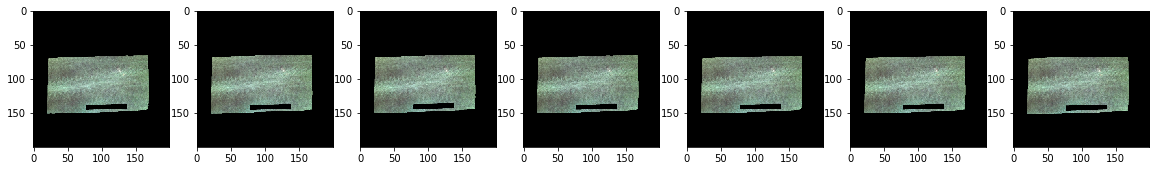

In [136]:
"""
Using bitwise function to apply the mask to the images so we do anomaly detection in only the area where all 10 input images are a part of the integrated image
"""

int_imgs = []

for i in range(len(integrated_images)):
    _Img = integrated_images[i].copy()
    int_imgs.append(cv2.bitwise_and(_Img,_Img, mask=mask_images[i].astype('uint8')))

display_images(int_imgs, figsize=(1,7), resize_dim=(200,200))

Start for image 0
It took 00:03:55
Start for image 1
It took 00:03:51
Start for image 2
It took 00:03:50
Start for image 3
It took 00:03:52
Start for image 4
It took 00:03:51
Start for image 5
It took 00:03:51
Start for image 6
It took 00:03:47


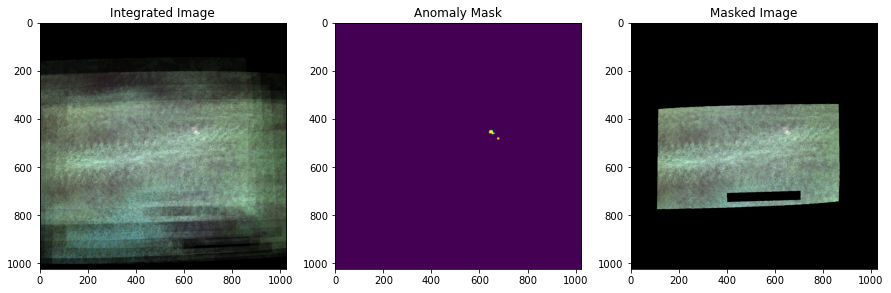

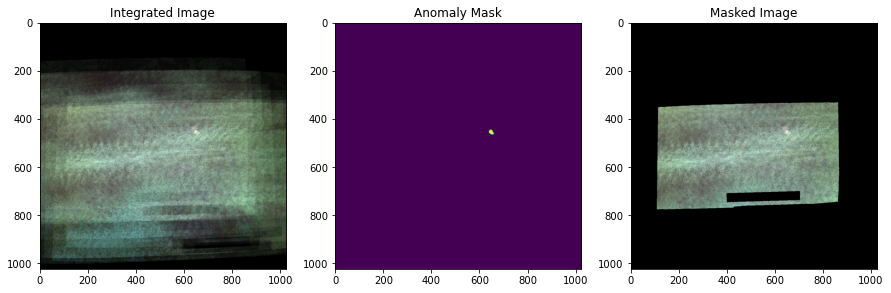

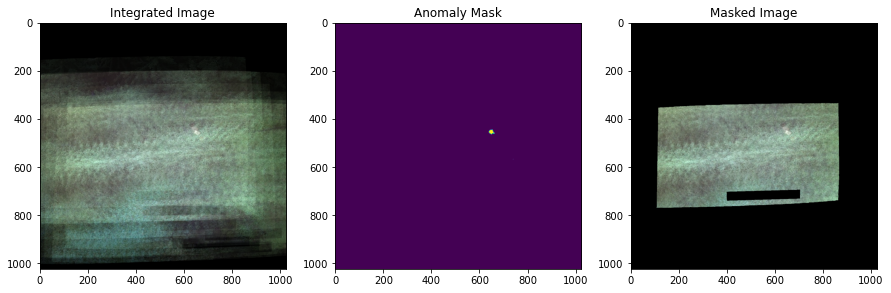

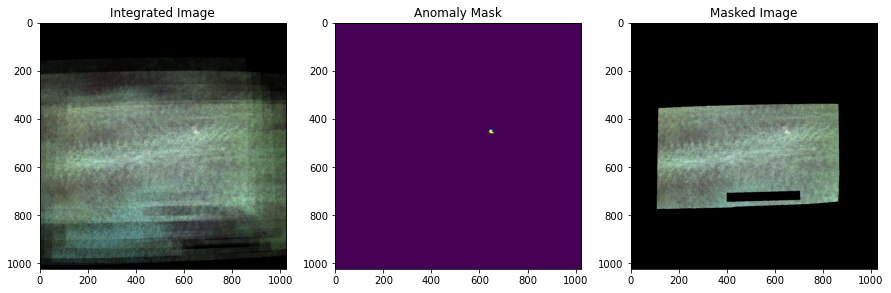

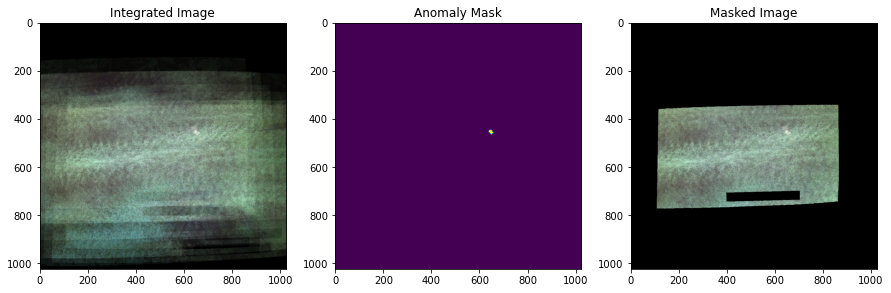

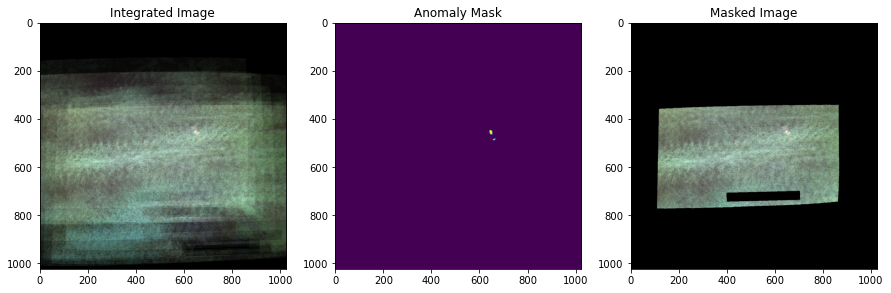

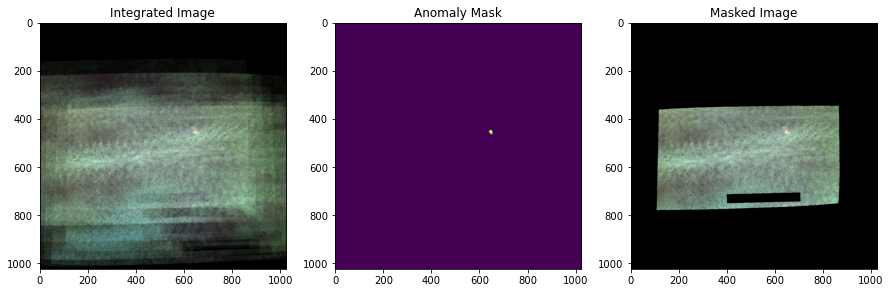

In [138]:
val_set = dict()

for i, int_image in enumerate(integrated_images):
    print(f"Start for image {i}")
    start = time()
    reducing = ResidualAnomaly(img=int_image)
    val_set[i] = reducing.anomaly_mask()
    print(f"It took {strftime('%H:%M:%S', gmtime(time()-start))}")

"""
for i, mask in val_set.items():
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    ax1.imshow(integrated_images[i])
    ax1.title.set_text("Integrated Image")

    ax2 = fig.add_subplot(122)
    ax2.imshow(mask)
    ax2.title.set_text("Anomaly Mask")
    plt.show()
"""

for i, mask in val_set.items():
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(131)
    ax1.imshow(integrated_images[i])
    ax1.title.set_text("Integrated Image")

    ax2 = fig.add_subplot(132)
    ax2.imshow(mask)
    ax2.title.set_text("Anomaly Mask")

    ax3 = fig.add_subplot(133)
    ax3.imshow(int_imgs[i])
    ax3.title.set_text("Masked Image")
    plt.show()

## Bounding Boxes

In [139]:
with open(os.path.join(IMAGE_FOLDER, 'labels.json'), 'r') as label_file:
    gtlabels = json.load(label_file)

val_img = cv2.imread('data/validation/valid-1-0/3-B01.png')

### Add given BB

In [140]:
def add_bounding_boxes(
        img: np.ndarray,
        gtlabels: List[List[int]],
        rgb_color: Tuple[int] = (0, 0, 255),
        thickness: int = 5
) -> np.ndarray:
    """
    Adds the given bounding boxes to an image. These bounding boxes are
    only aligned for the center image!

    Args:
        img: Image to which bounding boxes should be added
        gtlabels: Bounding boxes from a labels.json file
        rgb_color: Tuple representing the RGB color of the box
        thickness: Thickness of the box line

    Returns:
        Image with an overlayed bounding boxes
    """
    for bb in gtlabels:
        x, y, w, h = bb
        img = cv2.rectangle(
            img=img,
            pt1=(x,y),
            pt2=(x+w, y+h),
            color=rgb_color,
            thickness=thickness
        )

    return img

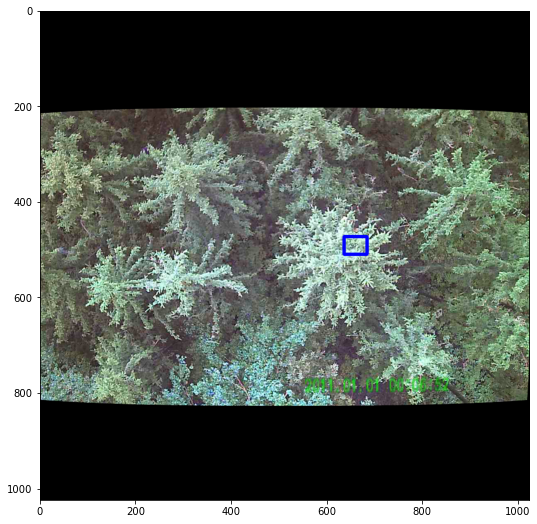

In [141]:
plt.figure(figsize=(9, 9))
plt.imshow(add_bounding_boxes(val_img, gtlabels))

### Create new BB from anomaly mask

In [142]:
"""
def get_bounding_boxes(image, mask):
    # Not sure if we need the mask on the integrated images?
    # res = cv2.bitwise_and(image,image,mask = mask)
    res=image
    contours = cv2.findContours(res.astype(np.uint8), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)[0]
    if len(contours):
        detected_anomalies_bb = np.stack([cv2.boundingRect(c) for c in contours])
    else:
        detected_anomalies_bb = np.zeros((0,4))

    return detected_anomalies_bb, contours
"""

'\ndef get_bounding_boxes(image, mask):\n    # Not sure if we need the mask on the integrated images?\n    # res = cv2.bitwise_and(image,image,mask = mask)\n    res=image\n    contours = cv2.findContours(res.astype(np.uint8), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)[0]\n    if len(contours):\n        detected_anomalies_bb = np.stack([cv2.boundingRect(c) for c in contours])\n    else:\n        detected_anomalies_bb = np.zeros((0,4))\n\n    return detected_anomalies_bb, contours\n'

In [143]:
def is_close(cnt1,cnt2, max_dist=30):
    row1,row2 = cnt1.shape[0],cnt2.shape[0]
    for i in range(row1):
        for j in range(row2):
            dist = np.linalg.norm(cnt1[i]-cnt2[j])
            if abs(dist) < max_dist:
                return True
            elif i==row1-1 and j==row2-1:
                return False

def combine_contours(contours, min_area):
    n = len(contours)
    status = np.zeros((n,1))
    
    for i,cnt1 in enumerate(contours):
        x = i    
        if i != n-1:
            for j,cnt2 in enumerate(contours[i+1:]):
                x = x+1
                dist = is_close(cnt1,cnt2)
                if dist:
                    val = min(status[i],status[x])
                    status[x] = status[i] = val
                else:
                    if status[x]==status[i]:
                        status[x] = i+1

    unified = []
    maximum = int(status.max())+1
    for i in range(maximum):
        pos = np.where(status==i)[0]
        if pos.size != 0:
            cont = np.vstack(contours[i] for i in pos)
            hull = cv2.convexHull(cont)
            if not cv2.contourArea(hull)< min_area:
                unified.append(hull)
                
    return unified

def area_filled(contour,mask):
    
    contour_area=np.zeros_like(mask)
    cv2.drawContours(contour_area, [contour], -1, 1, -1)
    
    total=contour_area.sum()
    mask_area=contour_area[mask.astype(bool)].sum()

    return mask_area.sum()/total

In [144]:
def get_bounding_boxes(image, mask, min_area=100, fill_threshold=0.3):
    
    contours = cv2.findContours(image.astype(np.uint8), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)[0]
    
    if not len(contours):
        detected_anomalies_bb = np.zeros((0,4))
        
        return detected_anomalies_bb, contours
        
    combined=combine_contours(contours, min_area)
    combined = [c for c in combined if not area_filled(c,mask)<fill_threshold]
    
    if not len(combined):
        detected_anomalies_bb = np.zeros((0,4))
        return detected_anomalies_bb, combined
    
    detected_anomalies_bb = np.stack([cv2.boundingRect(c) for c in combined])
    
    return detected_anomalies_bb, combined

C:\Users\wittw\AppData\Local\Temp/ipykernel_30104/1829812927.py:33: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  cont = np.vstack(contours[i] for i in pos)


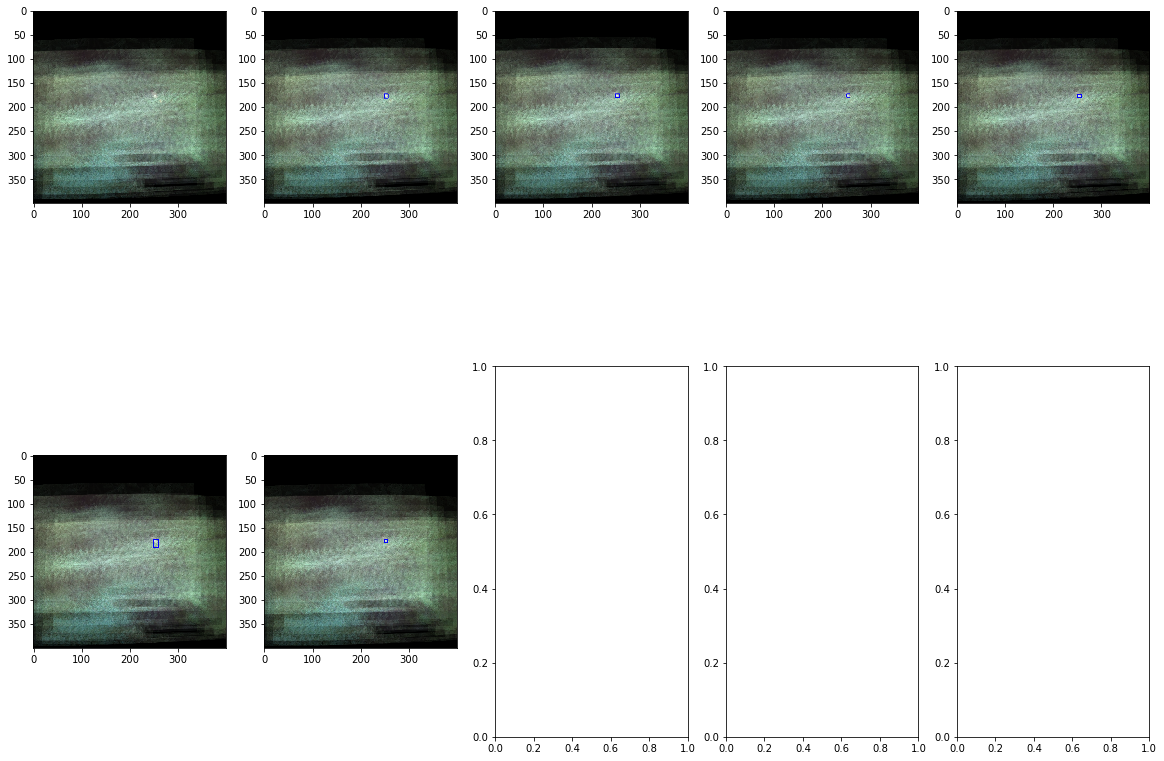

In [145]:
points_ = []

for i, img in val_set.items():
    b,c = get_bounding_boxes(img,mask)
    points_.append(b)


images_result = []

for z in range(len(points_)):
    tmp = integrated_images[z].copy()
    for cntr in points_[z]:
        x,y,w,h = cntr[0],cntr[1],cntr[2],cntr[3]
        cv2.rectangle(tmp, (x, y), (x+w, y+h), (0, 0, 255), 4)
    images_result.append(tmp)

display_images(np.array(images_result), figsize=(2,5), resize_dim=(400,400))